In [28]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import make_scorer, f1_score, accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_validate

In [29]:
sentiment_dataset = pd.read_csv("Sentiment140_filtered.csv")

In [30]:
sentiment_dataset.head()

,Unnamed: 0,target,ids,date,flag,user,text,hate_pred
0,750,0,1467998601,Mon Apr 06 23:11:18 PDT 2009,NO_QUERY,Young_J,I'm off too bed. I gotta wake up hella early t...,1
1,766711,0,2300049112,Tue Jun 23 13:40:12 PDT 2009,NO_QUERY,dougnawoschik,I havent been able to listen to it yet My spe...,1
2,285055,0,1993474319,Mon Jun 01 10:26:09 PDT 2009,NO_QUERY,thireven,now remembers why solving a relatively big equ...,1
3,705995,0,2256551006,Sat Jun 20 12:56:51 PDT 2009,NO_QUERY,taracollins086,"Ate too much, feel sick",1
4,379611,0,2052381070,Sat Jun 06 00:32:23 PDT 2009,NO_QUERY,Portablemonkey,Tried to purchase a parked domain through GoDa...,1


In [31]:
sentiment_dataset.isnull().sum()

Unnamed: 0    0
target        0
ids           0
date          0
flag          0
user          0
text          0
hate_pred     0
dtype: int64

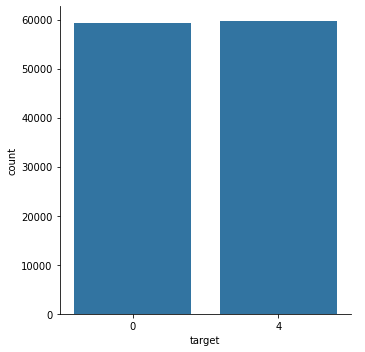

In [32]:
sns.catplot(x = 'target', data = sentiment_dataset, kind = 'count')


In [33]:
hateful_dataset = pd.read_csv("hateful_sentiment.csv")

In [34]:
hateful_dataset.head()

,Content,Label,Content_int
0,retweet to the rejects who constantly call my ...,1,"[146715, 1761, 7, 3, 22587, 67, 6768, 472, 129..."
1,i purpose that whatever attack everyone who ca...,1,"[146715, 80, 4226, 28, 220, 1347, 1568, 67, 65..."
2,are you fucking kidding me you deserve to fuck...,1,"[146715, 154, 26, 69, 1361, 78, 26, 6610, 7, 6..."
3,retweet i am not racist and i am not sexist i ...,1,"[146715, 1761, 80, 81, 76, 1723, 111, 80, 81, ..."
4,just imagine if the two million spent on the s...,1,"[146715, 14, 925, 204, 3, 672, 462, 5271, 9, 3..."


In [35]:
hateful_dataset = hateful_dataset[["Content", "Label"]]
hateful_dataset = hateful_dataset.rename(columns = {"Content": "text", "Label": "target"})
hateful_dataset["target"] = 2

hateful_dataset.head()

,text,target
0,retweet to the rejects who constantly call my ...,2
1,i purpose that whatever attack everyone who ca...,2
2,are you fucking kidding me you deserve to fuck...,2
3,retweet i am not racist and i am not sexist i ...,2
4,just imagine if the two million spent on the s...,2


In [36]:
sentiment_dataset = sentiment_dataset[["text", "target"]]
sentiment_dataset.head()

,text,target
0,I'm off too bed. I gotta wake up hella early t...,0
1,I havent been able to listen to it yet My spe...,0
2,now remembers why solving a relatively big equ...,0
3,"Ate too much, feel sick",0
4,Tried to purchase a parked domain through GoDa...,0


In [37]:
sentiment_dataset.loc[sentiment_dataset['target']==4, 'target'] = 1
#sentiment_dataset.loc[sentiment_dataset['target']==0, 'target'] = 0
# 0 - negative, 1 - positive, 2 - hateful


In [38]:
sentiment_dataset = pd.concat([sentiment_dataset, hateful_dataset], ignore_index= True)

In [39]:
sentiment_dataset.head()

,text,target
0,I'm off too bed. I gotta wake up hella early t...,0
1,I havent been able to listen to it yet My spe...,0
2,now remembers why solving a relatively big equ...,0
3,"Ate too much, feel sick",0
4,Tried to purchase a parked domain through GoDa...,0


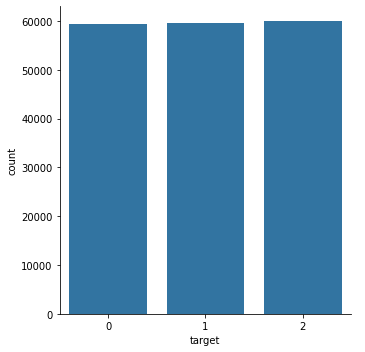

In [40]:
sns.catplot(x = 'target', data = sentiment_dataset, kind = 'count')

In [41]:
sentiment_dataset['target'].value_counts()

target
2    60000
1    59700
0    59300
Name: count, dtype: int64

In [42]:
sentiment_dataset.isnull().sum()

text      0
target    0
dtype: int64

CNN

In [43]:
X = sentiment_dataset['text']
y = sentiment_dataset['target']

In [ ]:
# Tokenizacja i czyszczenie tekstu
from collections import Counter
import re

def tokenize(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)
    return text.split()

# Tworzenie słownika
all_tokens = [token for text in sentiment_dataset['text'] for token in tokenize(text)]
vocab = {word: i+2 for i, (word, _) in enumerate(Counter(all_tokens).most_common(10000))}
vocab['<PAD>'] = 0
vocab['<UNK>'] = 1

def encode(text):
    return [vocab.get(token, 1) for token in tokenize(text)]

In [ ]:
# vectorizer = TfidfVectorizer(max_features=1000)
# X_tfidf = vectorizer.fit_transform(X).toarray()
# y_adj = sentiment_dataset['target'].values

In [ ]:
class TextDataset(Dataset):
    def __init__(self, X, y):
        #self.X = torch.tensor(X, dtype=torch.float32)
        #self.y = torch.tensor(y.values if isinstance(y, pd.Series) else y, dtype=torch.long)
        self.X = [torch.tensor(encode(text)) for text in X]
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [23]:
# class TextCNN(nn.Module):
#     def __init__(self, input_dim, num_classes):
#         super(TextCNN, self).__init__()
#         self.conv1 = nn.Conv1d(in_channels=1, out_channels=100, kernel_size=3)
#         self.relu = nn.ReLU()
#         self.pool = nn.AdaptiveMaxPool1d(1)
#         self.fc = nn.Linear(100, num_classes)

#     def forward(self, x):
#         x = x.unsqueeze(1)  # [B, 1, D]
#         x = self.conv1(x)   # [B, C, D-K+1]
#         x = self.relu(x)
#         x = self.pool(x).squeeze(2)  # [B, C]
#         return self.fc(x)

import torch.nn as nn
import torch.nn.functional as F

class TextCNN(nn.Module):
    def __init__(self, input_dim, num_classes, num_filters=100, dropout=0.5):
        super(TextCNN, self).__init__()

        kernel_sizes = [3, 4, 5]
        self.convs = nn.ModuleList([
            nn.Conv1d(in_channels=1, out_channels=num_filters, kernel_size=k)
            for k in kernel_sizes
        ])

        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(num_filters * len(kernel_sizes), num_classes)

    def forward(self, x):
        x = x.unsqueeze(1)  # [B, 1, D]
        conv_outputs = []

        for conv in self.convs:
            c = conv(x)                         # [B, num_filters, D-k+1]
            c = F.relu(c)
            c = F.max_pool1d(c, kernel_size=c.shape[2])  # [B, num_filters, 1]
            conv_outputs.append(c.squeeze(2))  # [B, num_filters]

        out = torch.cat(conv_outputs, dim=1)   # [B, num_filters * len(kernel_sizes)]
        out = self.dropout(out)
        return self.fc(out)


In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_dim = X_tfidf.shape[1]
num_classes = 3 
batch_size = 64
epochs = 10
criterion = nn.CrossEntropyLoss()


In [25]:
print(type(X_tfidf))  # Sprawdź typ X_tfidf (powinno to być np. numpy.ndarray)
print(type(y_adj))    # Sprawdź typ y_adj (powinno to być np. numpy.ndarray lub pd.Series)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [26]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold = 0
results = []

for train_idx, val_idx in skf.split(X_tfidf, y):
    fold += 1
    print(f"\n=== Fold {fold} ===")

    X_train, X_val = X_tfidf[train_idx], X_tfidf[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    train_dataset = TextDataset(X_train, y_train)
    val_dataset = TextDataset(X_val, y_val)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    model = TextCNN(input_dim=input_dim, num_classes=3).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    best_acc = 0
    for epoch in range(epochs):
        # Trenowanie
        model.train()
        total_loss = 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            output = model(xb)
            loss = criterion(output, yb)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        # Walidacja
        model.eval()
        val_loss = 0
        y_preds, y_trues = [], []
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                output = model(xb)
                loss = criterion(output, yb)
                val_loss += loss.item()
                preds = torch.argmax(output, dim=1).cpu().numpy()
                y_preds.extend(preds)
                y_trues.extend(yb.cpu().numpy())

        val_loss_avg = val_loss / len(val_loader)
        val_acc = accuracy_score(y_trues, y_preds)

        print(f"Epoch {epoch+1}: Train Loss={total_loss:.4f}, Val Loss={val_loss_avg:.4f}, Val Acc={val_acc:.4f}")

        if val_acc > best_acc:
            best_acc = val_acc
            model_path = f"best_model_fold{fold}.pt"
            torch.save(model.state_dict(), model_path)

    # Po epokach: ewaluacja końcowa
    precision = precision_score(y_trues, y_preds, average='macro', zero_division=0)
    recall = recall_score(y_trues, y_preds, average='macro', zero_division=0)
    cm = confusion_matrix(y_trues, y_preds)

    results.append({
        "fold": fold,
        "accuracy": val_acc,
        "precision": precision,
        "recall": recall,
        "confusion_matrix": cm
    })



=== Fold 1 ===
Epoch 1: Train Loss=2454.6362, Val Loss=1.0914, Val Acc=0.3760


KeyboardInterrupt: 

In [ ]:
# Podsumowanie
for res in results:
    print(f"\nFold {res['fold']}:")
    print(f"Accuracy: {res['accuracy']:.4f}")
    print(f"Precision: {res['precision']:.4f}")
    print(f"Recall: {res['recall']:.4f}")
    print(f"Confusion Matrix:\n{res['confusion_matrix']}")